# 依赖歧义检测分析

本notebook专门针对用户故事中的**依赖歧义**进行检测和分析。

In [1]:
from ambiguity_detection_utils import AmbiguityDetector

detector = AmbiguityDetector("dependency")
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=False)

print(f"测试数据集: {len(df_test)} 个用户故事")

Dependency歧义统计:
  有dependency歧义: 192 (1.5%)
  无dependency歧义: 12655 (98.5%)
使用所有可用数据: 12847 个用户故事
  HasAmbiguity=True: 192 (1.5%)
  HasAmbiguity=False: 12655 (98.5%)
=== Dependency歧义检测评估 ===
测试数据集: 12847 个用户故事
Processing model gpt-3.5-turbo...
API call failed (gpt-3.5-turbo): Connection error.
  Processed 10/20 samples
  Processed 20/20 samples
  Dependency Ambiguity Detection - Precision: 0.000, Recall: 0.000, F1: 0.000
Processing model deepseek-chat...
  Processed 10/20 samples
  Processed 20/20 samples
  Dependency Ambiguity Detection - Precision: 0.000, Recall: 0.000, F1: 0.000


In [ ]:
sample_size = detector.get_recommended_sample_size()
results = detector.run_evaluation(df_test, sample_size=sample_size, prompt_generator=detector.generate_prompt)

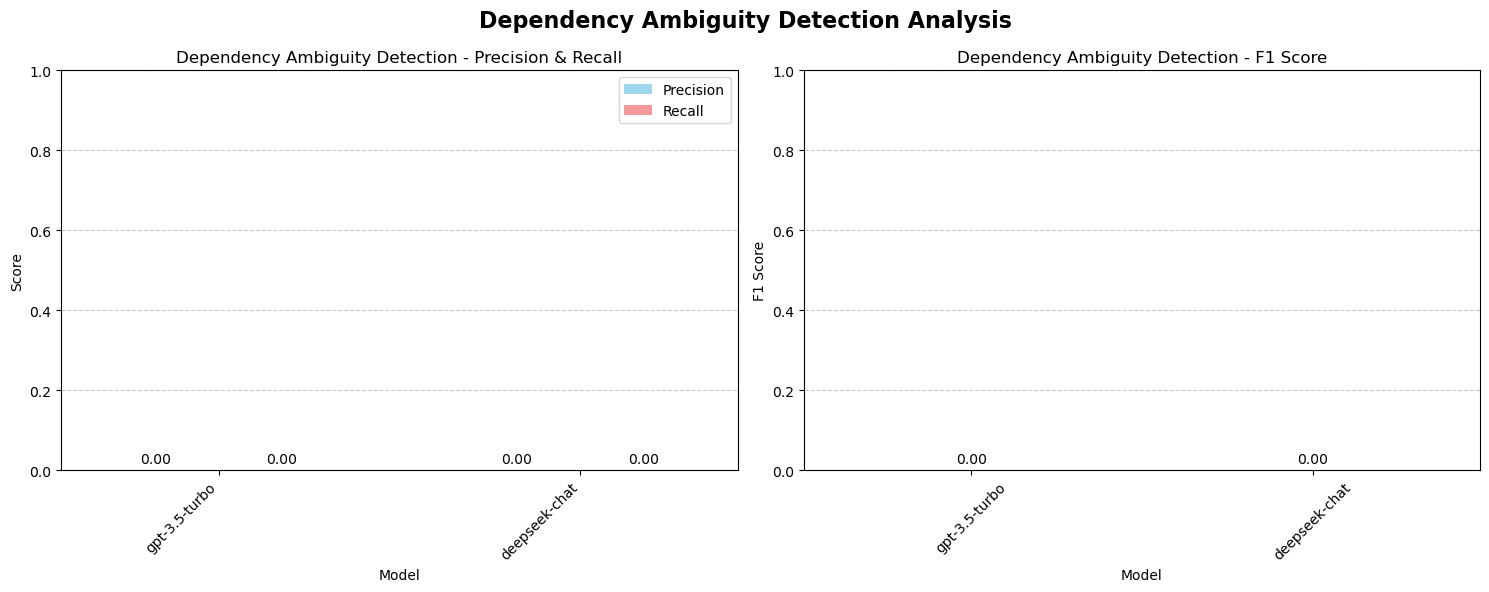

结果已保存到 dependency_ambiguity_evaluation_results.json

=== Dependency歧义检测评估总结 ===

Model: gpt-3.5-turbo
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000

Model: deepseek-chat
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000


In [2]:
detector.create_visualization(results, save_prefix="dependency")
detector.save_results(results, "dependency_ambiguity_evaluation_results.json")
detector.print_summary(results)

In [3]:
from ambiguity_detection_utils import analyze_errors
analyze_errors(results, "dependency", num_examples=3)


=== Dependency歧义错误分析 ===

分析模型: gpt-3.5-turbo (F1: 0.000)

误报 (False Positives): 20 个
漏报 (False Negatives): 0 个

误报示例 (模型认为有歧义，实际无歧义):

1. 用户故事: As a customer, I want to troubleshoot connection so that I can optimize performance
   模型识别的歧义部分: unknown
   模型推理: parsing/api error

2. 用户故事: As a investor, I need to process application so I can meet financial goals
   模型识别的歧义部分: unknown
   模型推理: unknown

3. 用户故事: As a customer, I need to update information so that I have better track spending with detailed specifications and comprehensive requirements
   模型识别的歧义部分: unknown
   模型推理: unknown

漏报示例 (实际有歧义，模型未检测到):
